In [82]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [83]:
# Load dataset
df = pd.read_csv('../01_Dataset/EV_Predictive_Maintenance_Dataset.csv')
print(f"Dataset loaded: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"\nSoH range: {df['SoH'].min():.4f} to {df['SoH'].max():.4f}")
print(f"SoH mean: {df['SoH'].mean():.4f}")

Dataset loaded: 175,393 rows × 30 columns

SoH range: 0.4000 to 1.0000
SoH mean: 0.8822


In [84]:
# Convert Timestamp and sort chronologically
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df = df.sort_values('Timestamp').reset_index(drop=True)
print("Data sorted by Timestamp for time-series consistency")

Data sorted by Timestamp for time-series consistency


In [85]:
# Feature Engineering
df['Power_Load'] = df['Battery_Voltage'] * abs(df['Battery_Current'])
df['Temp_Diff'] = df['Battery_Temperature'] - df['Ambient_Temperature']
print("Engineered features created: Power_Load, Temp_Diff")

Engineered features created: Power_Load, Temp_Diff


In [86]:
# Select features for SoH prediction
# Focus on battery-related and operational features, avoiding data leakage
feature_columns = [
    'Battery_Voltage',
    'Battery_Current', 
    'Battery_Temperature',
    'Charge_Cycles',
    'Power_Consumption',
    'Driving_Speed',
    'Ambient_Temperature',
    'Ambient_Humidity',
    'Power_Load',
    'Temp_Diff'
]

X = df[feature_columns].copy()
y = df['SoH'].copy()

print(f"Selected {len(feature_columns)} features")
print(f"Feature shape: {X.shape}")
print(f"Target shape: {y.shape}")

Selected 10 features
Feature shape: (175393, 10)
Target shape: (175393,)


In [87]:
# Time-series train-test split (80/20)
split_idx = int(len(X) * 0.8)

X_train = X[:split_idx]
X_test = X[split_idx:]
y_train = y[:split_idx]
y_test = y[split_idx:]

print(f"Training set: {X_train.shape[0]:,} samples")
print(f"Test set: {X_test.shape[0]:,} samples")
print(f"Split: {X_train.shape[0]/len(X)*100:.1f}% train / {X_test.shape[0]/len(X)*100:.1f}% test")

Training set: 140,314 samples
Test set: 35,079 samples
Split: 80.0% train / 20.0% test


In [88]:
# Scale features only (NOT the target)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Feature scaling completed using StandardScaler")
print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"X_test_scaled shape: {X_test_scaled.shape}")
print(f"\ny_train range: {y_train.min():.4f} to {y_train.max():.4f} (NOT scaled)")
print(f"y_test range: {y_test.min():.4f} to {y_test.max():.4f} (NOT scaled)")

Feature scaling completed using StandardScaler
X_train_scaled shape: (140314, 10)
X_test_scaled shape: (35079, 10)

y_train range: 0.4000 to 1.0000 (NOT scaled)
y_test range: 0.4000 to 1.0000 (NOT scaled)


In [89]:
from xgboost import XGBRegressor
import time

In [90]:
# Initialize XGBoost model with aggressive hyperparameters
xgb_model = XGBRegressor(
    n_estimators=1500,
    learning_rate=0.01,
    max_depth=9,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0,
    reg_alpha=0,
    reg_lambda=0,
    objective='reg:squarederror',
    n_jobs=-1,
    random_state=42
)

print("XGBoost model initialized")
print(f"n_estimators: 1500, learning_rate: 0.01, max_depth: 9")

XGBoost model initialized
n_estimators: 1500, learning_rate: 0.01, max_depth: 9


In [91]:
# Train the model
print("Training XGBoost model...")
start_time = time.time()

xgb_model.fit(X_train_scaled, y_train, verbose=100)

training_time = time.time() - start_time
print(f"\nTraining completed in {training_time:.2f} seconds")

Training XGBoost model...

Training completed in 6.18 seconds


In [92]:
# Make predictions
y_pred = xgb_model.predict(X_test_scaled)
print("Predictions generated")

Predictions generated


In [93]:
# Calculate evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("="*60)
print("XGBoost Model Performance Metrics")
print("="*60)
print(f"Root Mean Squared Error (RMSE): {rmse:.6f}")
print(f"Mean Absolute Error (MAE):      {mae:.6f}")
print(f"R-squared (R²) Score:           {r2:.6f}")
print("="*60)
print(f"\nFor context: SoH range is {y_test.min():.4f} to {y_test.max():.4f}")

XGBoost Model Performance Metrics
Root Mean Squared Error (RMSE): 0.167528
Mean Absolute Error (MAE):      0.117319
R-squared (R²) Score:           -0.013137

For context: SoH range is 0.4000 to 1.0000


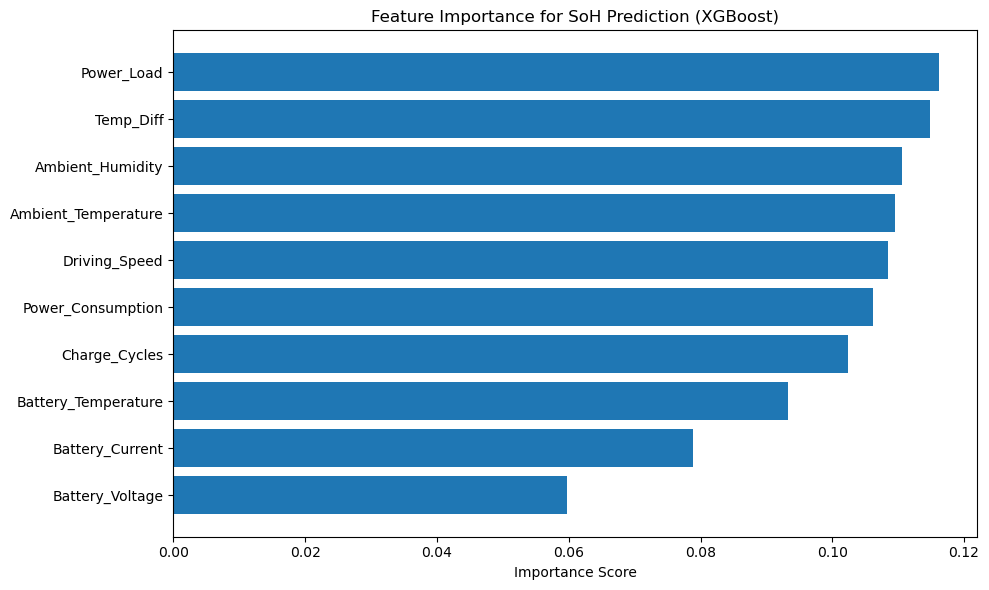


Feature Importance Ranking:
               Feature  Importance
8           Power_Load    0.116154
9            Temp_Diff    0.114792
7     Ambient_Humidity    0.110643
6  Ambient_Temperature    0.109557
5        Driving_Speed    0.108410
4    Power_Consumption    0.106211
3        Charge_Cycles    0.102401
2  Battery_Temperature    0.093250
1      Battery_Current    0.078880
0      Battery_Voltage    0.059703


In [94]:
# Feature importance
importance_df = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(range(len(importance_df)), importance_df['Importance'])
plt.yticks(range(len(importance_df)), importance_df['Feature'])
plt.xlabel('Importance Score')
plt.title('Feature Importance for SoH Prediction (XGBoost)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nFeature Importance Ranking:")
print(importance_df)

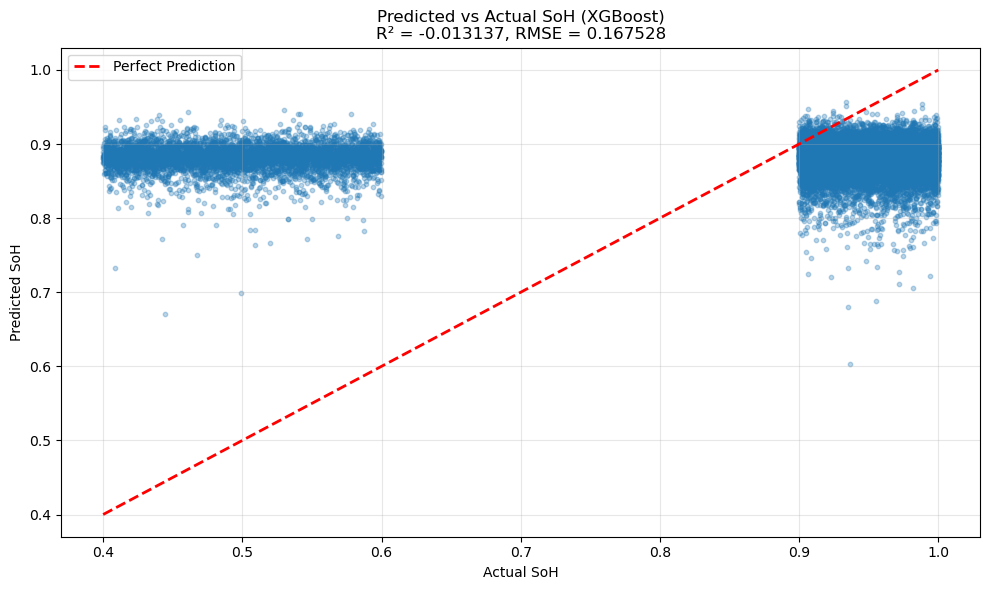

In [95]:
# Predicted vs Actual plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3, s=10)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
         'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual SoH')
plt.ylabel('Predicted SoH')
plt.title(f'Predicted vs Actual SoH (XGBoost)\nR² = {r2:.6f}, RMSE = {rmse:.6f}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()